In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
import matplotlib

In [3]:
# reading in daily rating data for 500 users randomly sampled from active users in month August 2024
# usernames extracted from openly accessible lichess dataset: https://database.lichess.org/

all_ratings = pd.read_csv("../data/all_ratings_users_active_in_Aug24.csv")
all_ratings["date"] = all_ratings["date"].apply(pd.Timestamp)

## Example Rating Plots with Weighted Mean

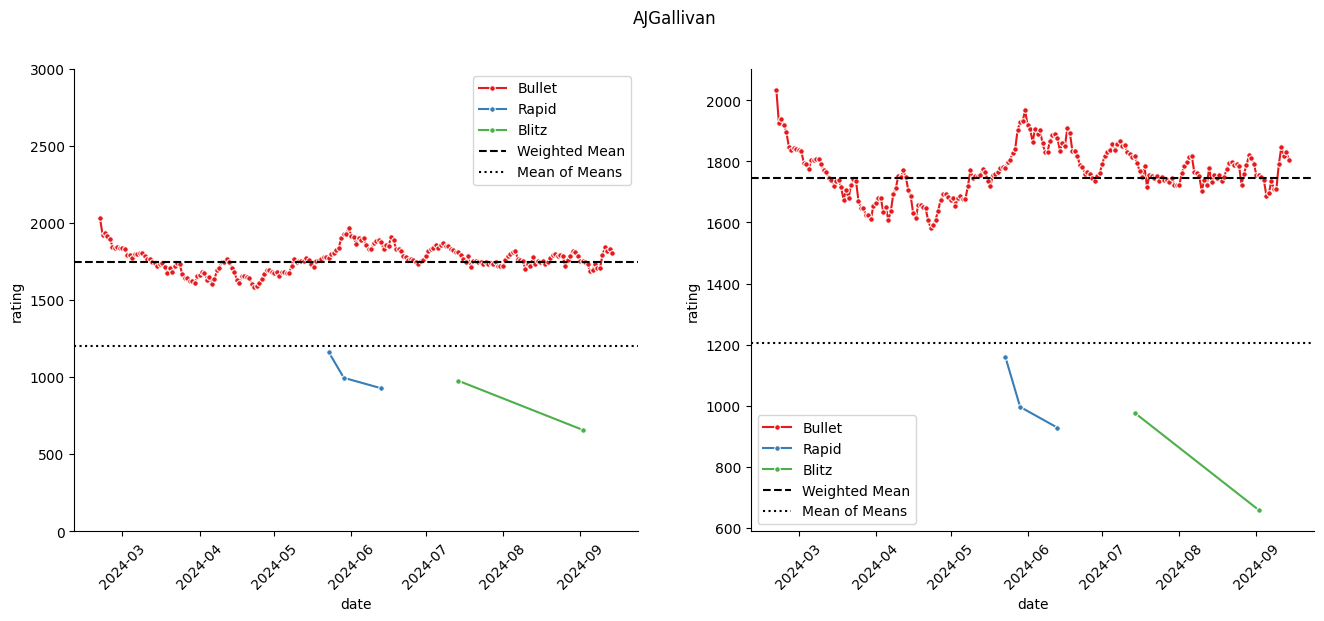

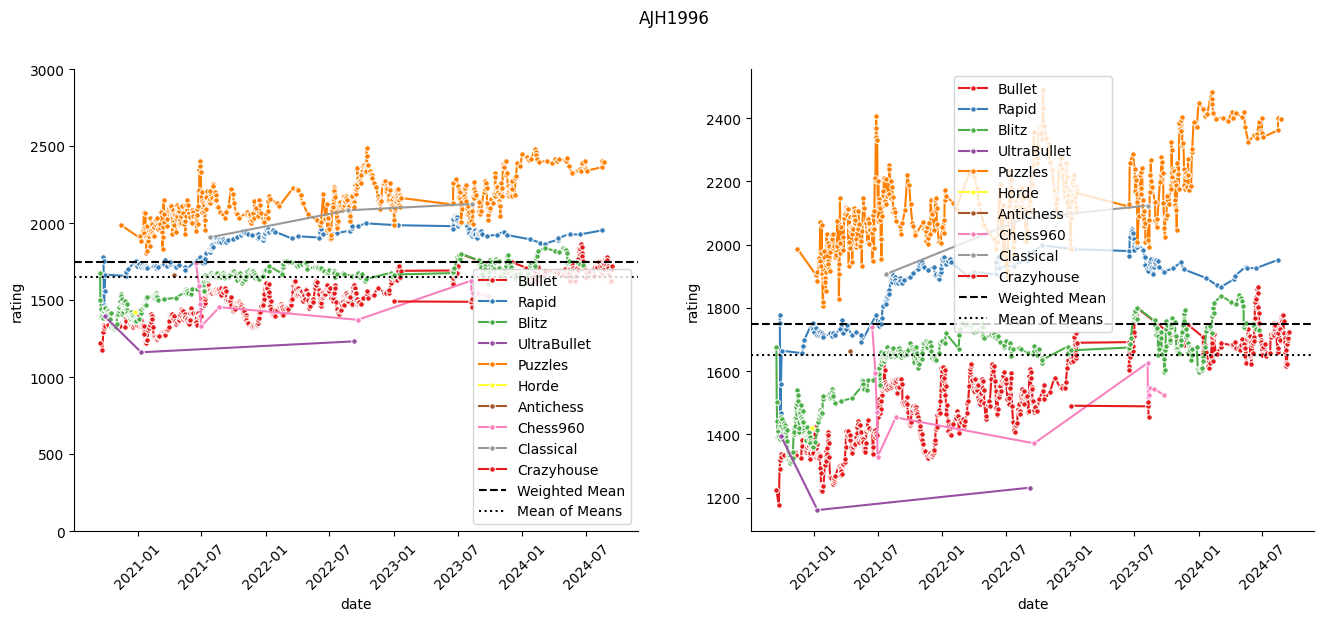

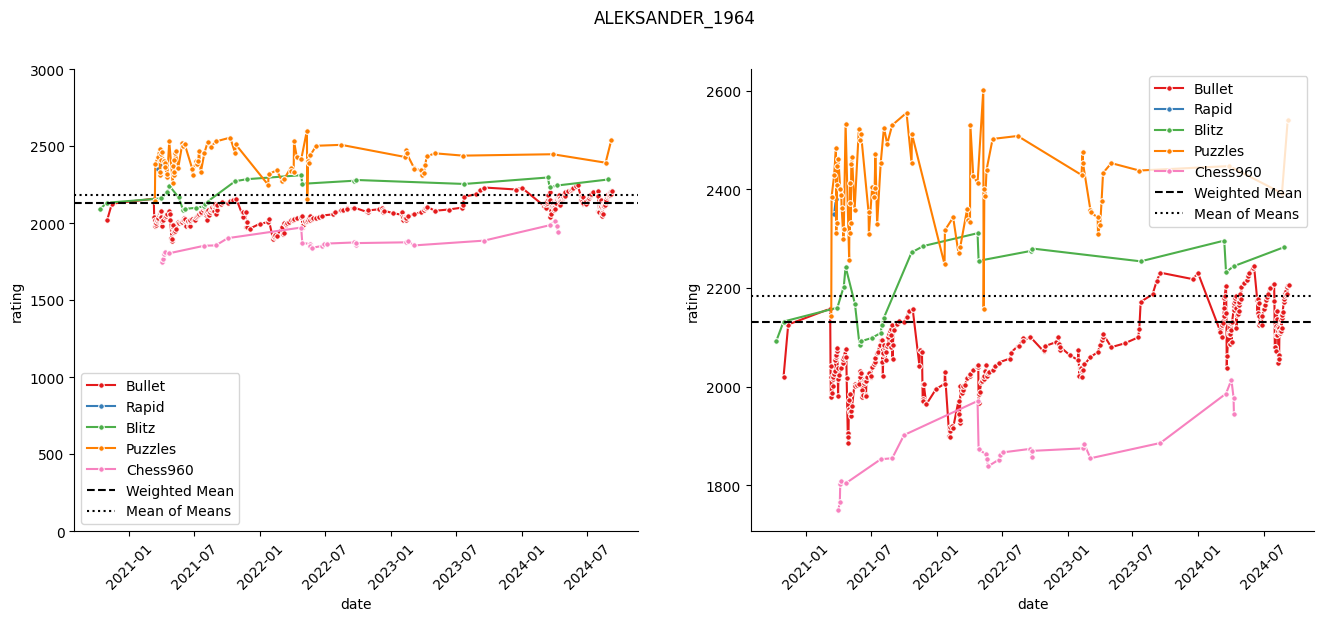

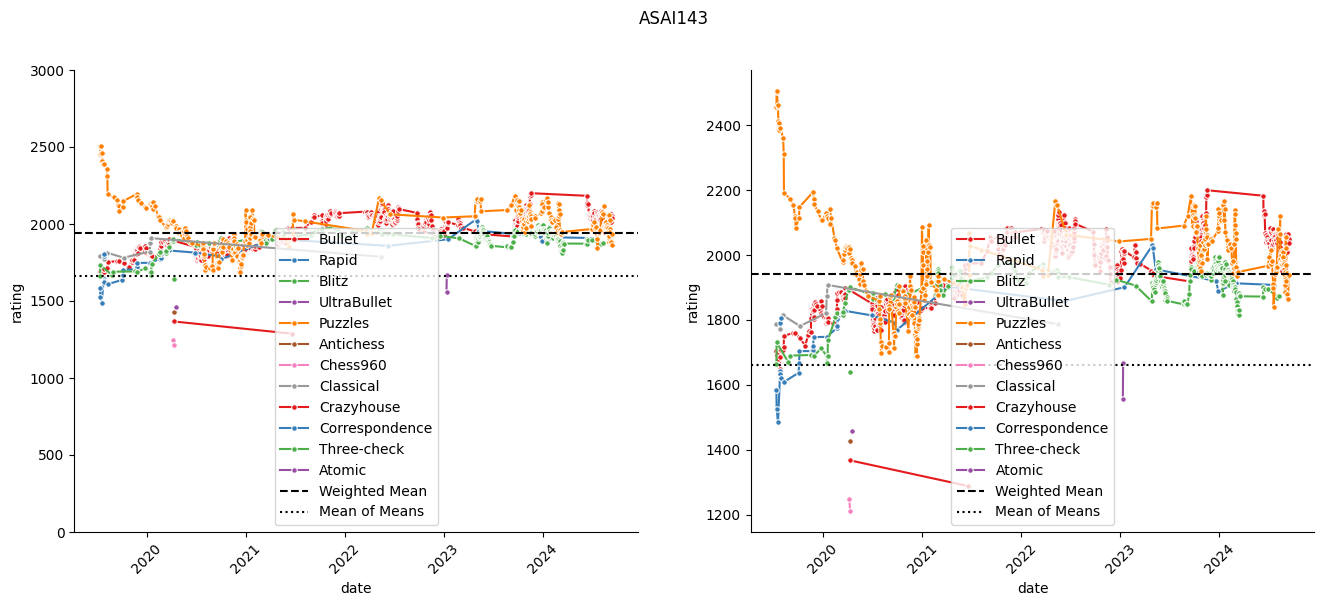

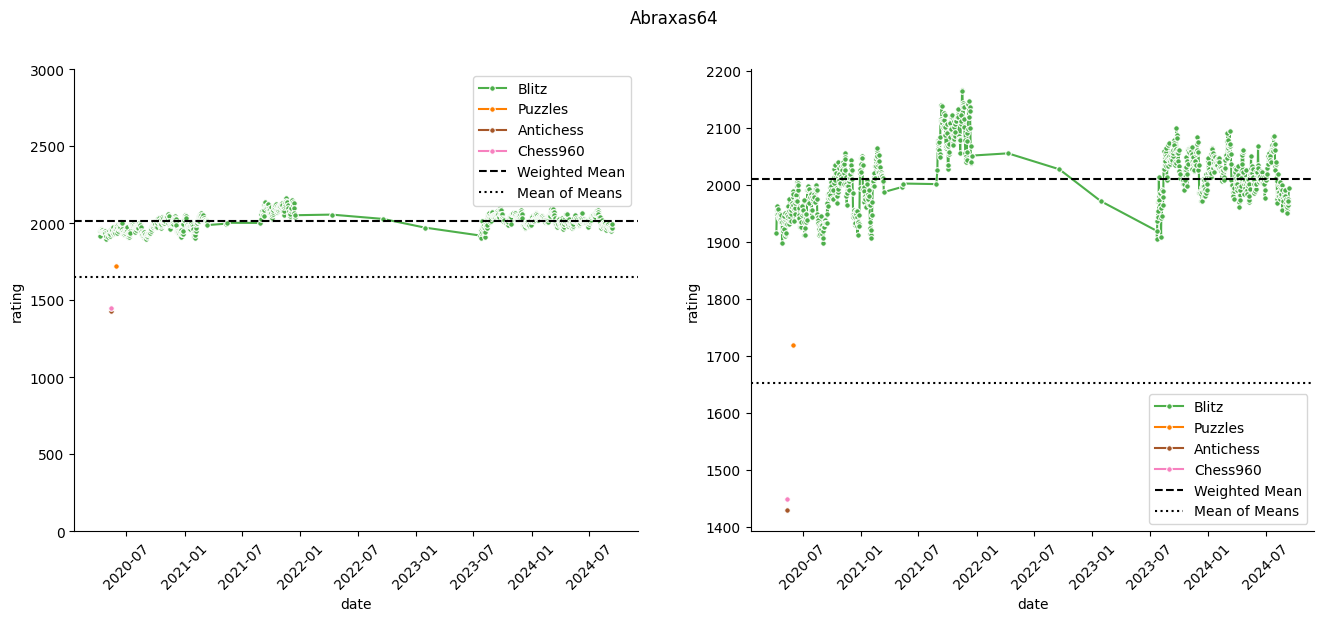

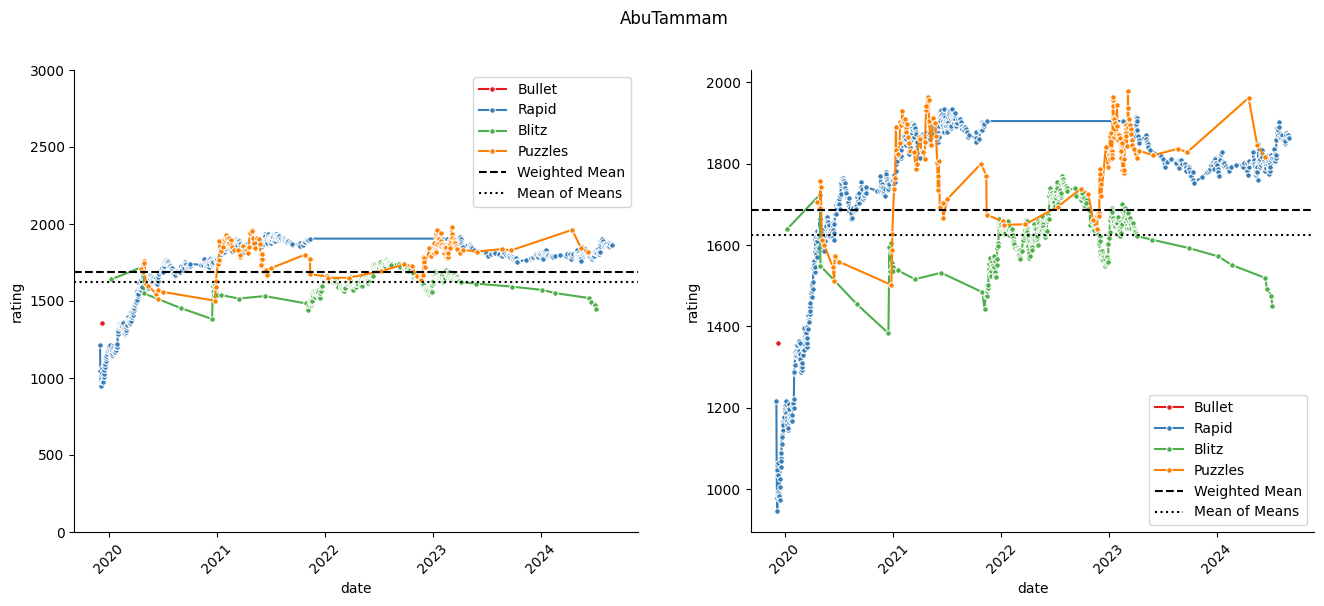

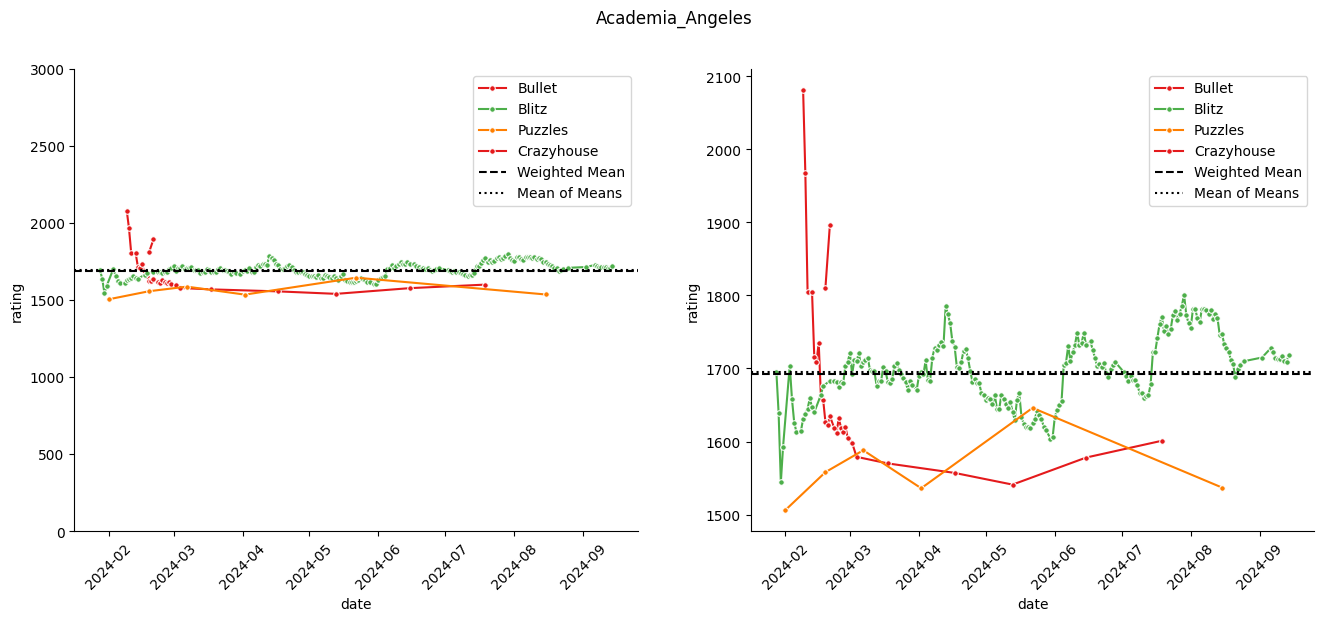

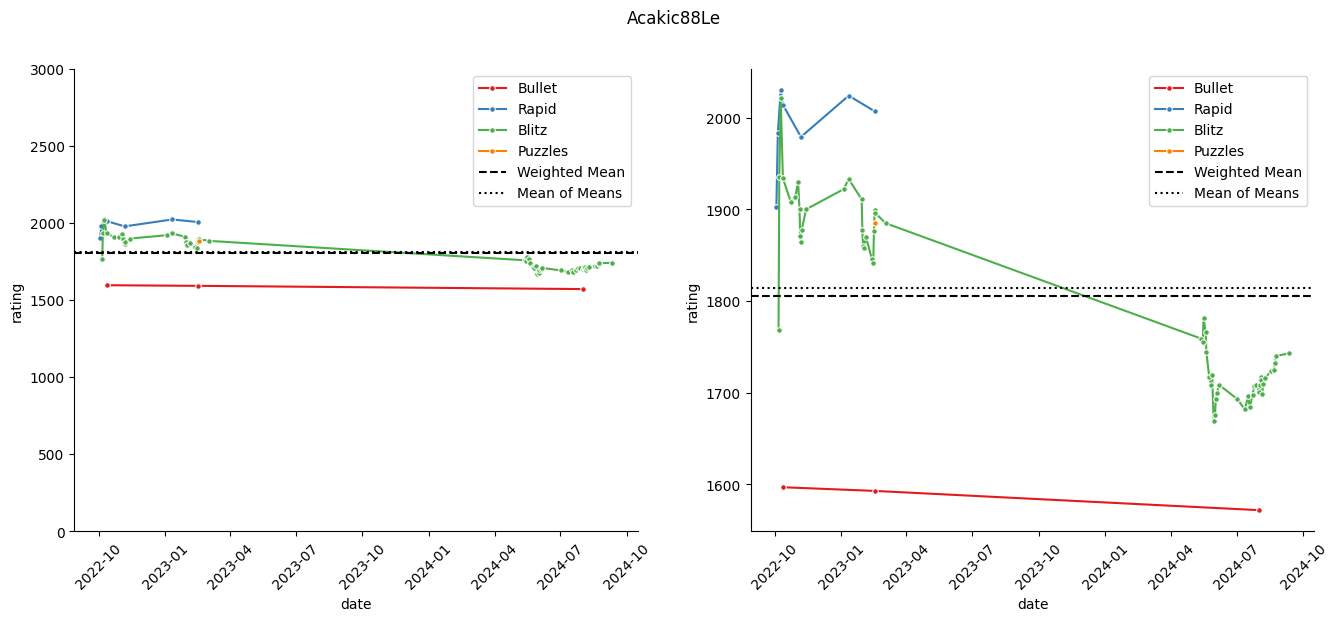

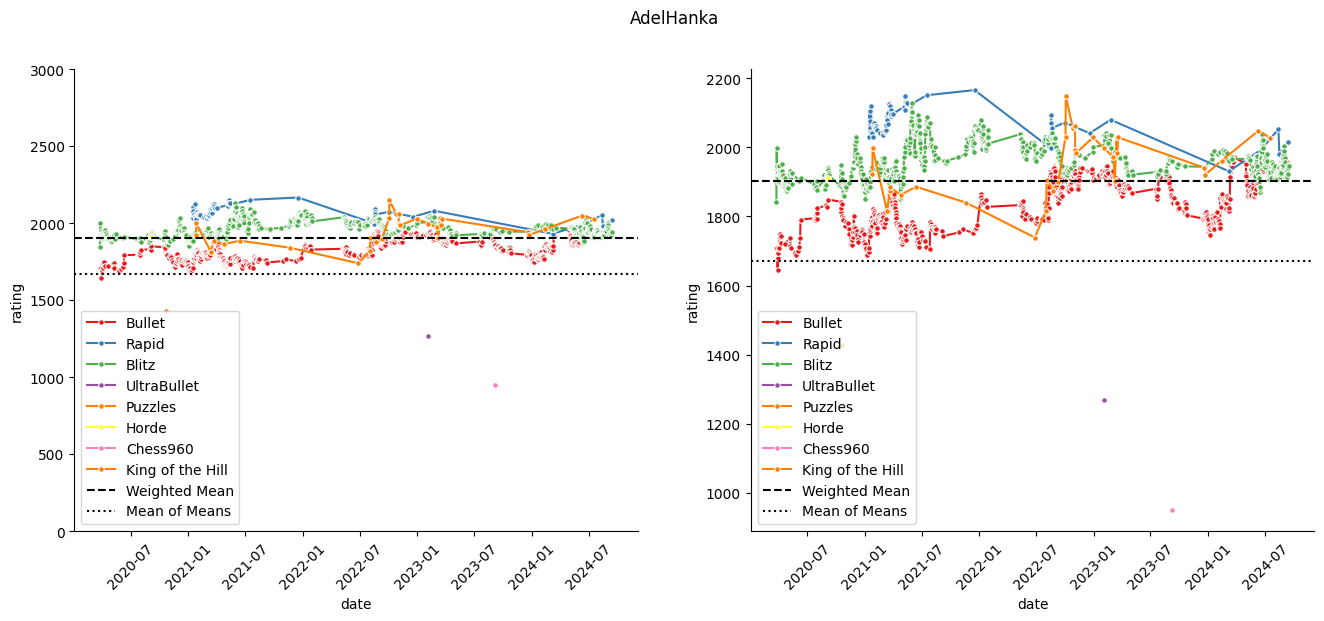

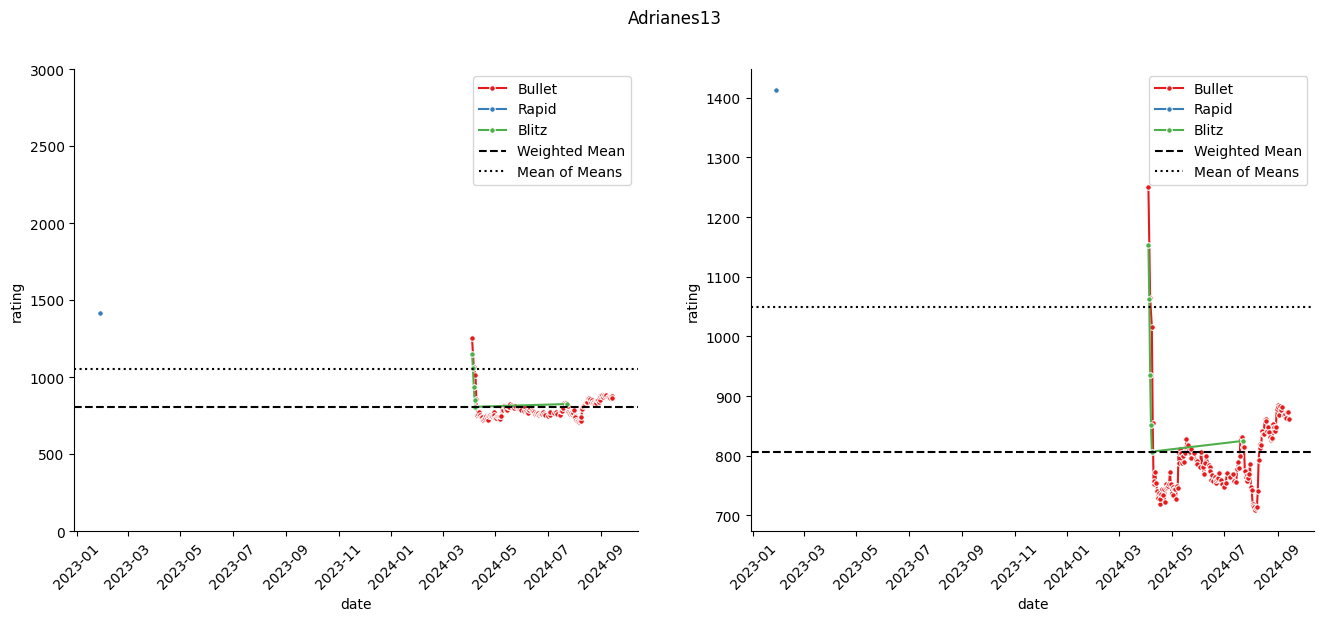

In [28]:
usernames = all_ratings["username"].unique()
sns.set_palette("Set1")
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
for user in usernames[:10]: # plot first 10 users
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    for i in range(2):
        subset = all_ratings[all_ratings['username'] == user]
        # sort ratings by date:
        subset = subset.sort_values(by='date')
        sns.lineplot(
            subset, 
            x="date", 
            y="rating", 
            hue="mode", 
            hue_order=all_ratings["mode"].unique(), 
            palette="Set1",
            marker=".", 
            markersize= 8, 
            ax=ax[i])
        plt.suptitle(user)
        if i ==0:
            ax[i].set_ylim((0,3000))
        # Add weighted mean:
        weighted_mean_line = ax[i].axhline(subset["rating"].mean(), 0, 1, color="black", linestyle="--", label='Weighted Mean')
        # Add mean of means:
        mean_of_means_line = ax[i].axhline(np.mean(subset.groupby("mode")["rating"].mean()), 0, 1, color="black", linestyle=":", label='Mean of Means')
        
        occurring_modes = subset["mode"].unique()
        handles, labels = ax[i].get_legend_handles_labels()
        indices = [i for i, label in enumerate(labels) if label in occurring_modes]
        line = Line2D([0], [0], label='manual line', color='k')

        ax[i].legend(
            handles=[handles[i] for i in indices]+[weighted_mean_line, mean_of_means_line], 
            labels=[labels[i] for i in indices]+ ['Weighted Mean', 'Mean of Means'])
        ax[i].tick_params(axis='x', rotation=45)
    plt.show()

### Avg Rating Significantly Predicts log(#Days Quitting Time)

                            OLS Regression Results                            
Dep. Variable:        days_since_prev   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     5.955
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0150
Time:                        16:48:43   Log-Likelihood:                -551.65
No. Observations:                 497   AIC:                             1107.
Df Residuals:                     495   BIC:                             1116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0761      0.140      7.687      0.0

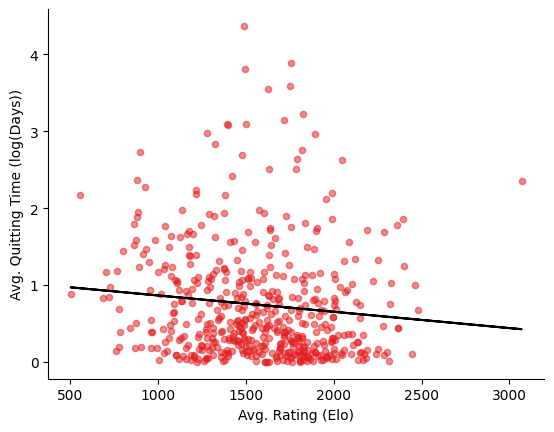

In [23]:
data = all_ratings[["username","rating","days_since_prev"]]
data = data[data["days_since_prev"]> 0] #exclude entries when user played multiple game modes in one day
avg_ratings = data.groupby("username")["rating"].mean()
avg_quitting_times = np.log(data.groupby("username")["days_since_prev"].mean())

#fit linear regression model
X = avg_ratings
y = avg_quitting_times
X = sm.add_constant(X)
model = sm.OLS(avg_quitting_times, X).fit()

#view model summary
print(model.summary())

#get parameters for plotting reg. line
intercept, slope = model.params

regression_line = slope * np.array(avg_ratings) + intercept
_ = plt.scatter(avg_ratings, avg_quitting_times, alpha = 0.5, s=20)
_ = plt.plot(avg_ratings, regression_line, color='black', label='Fitted line')
_ = plt.xlabel("Avg. Rating (Elo)")
_ = plt.ylabel("Avg. Quitting Time (log(Days))")

## Calculating/Visualizing Rating Slopes

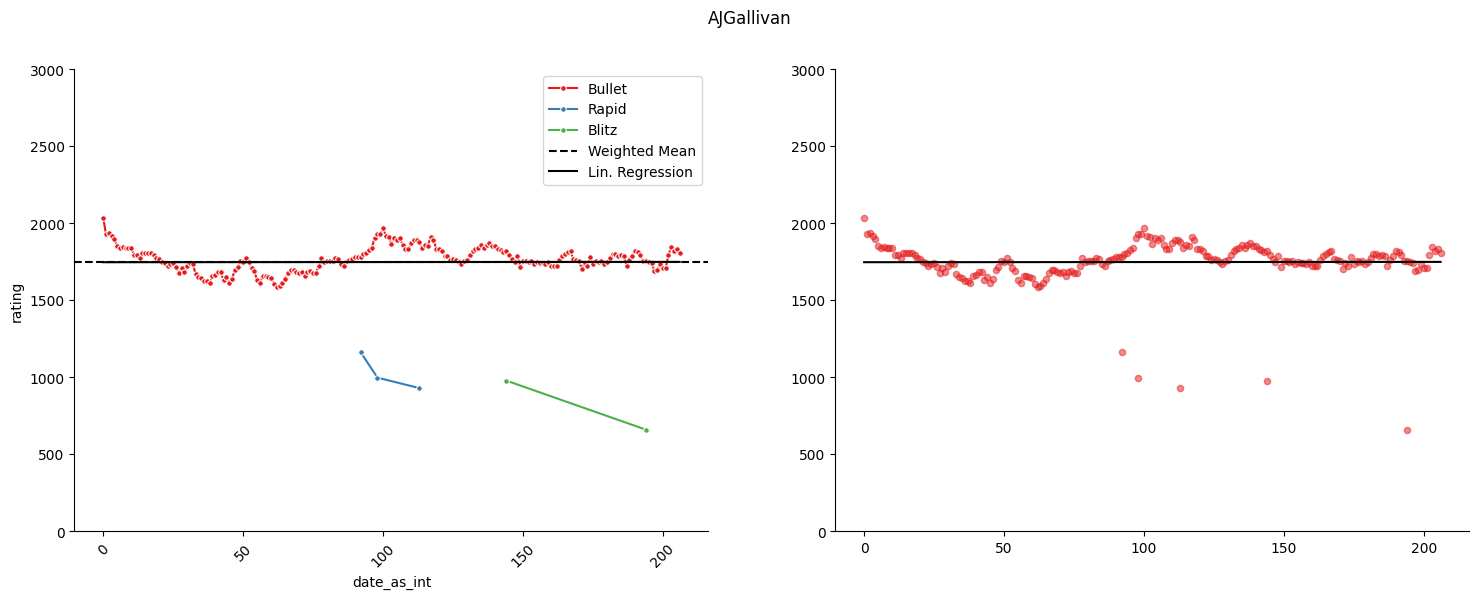

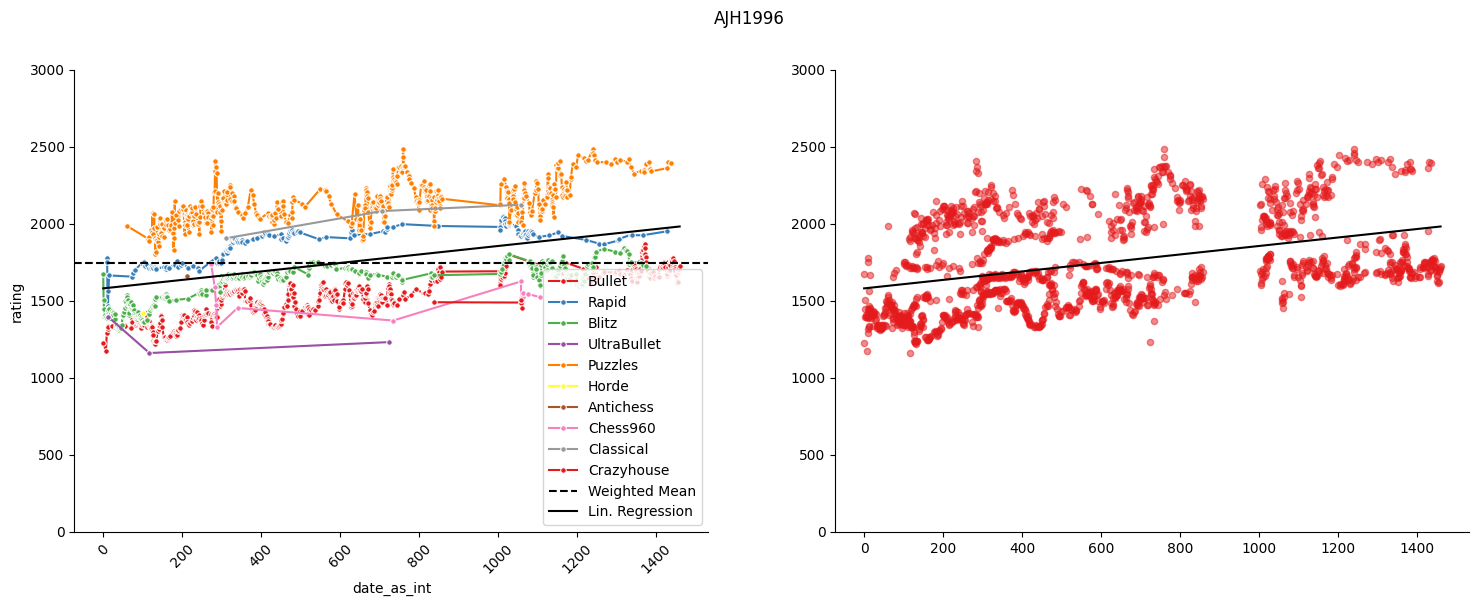

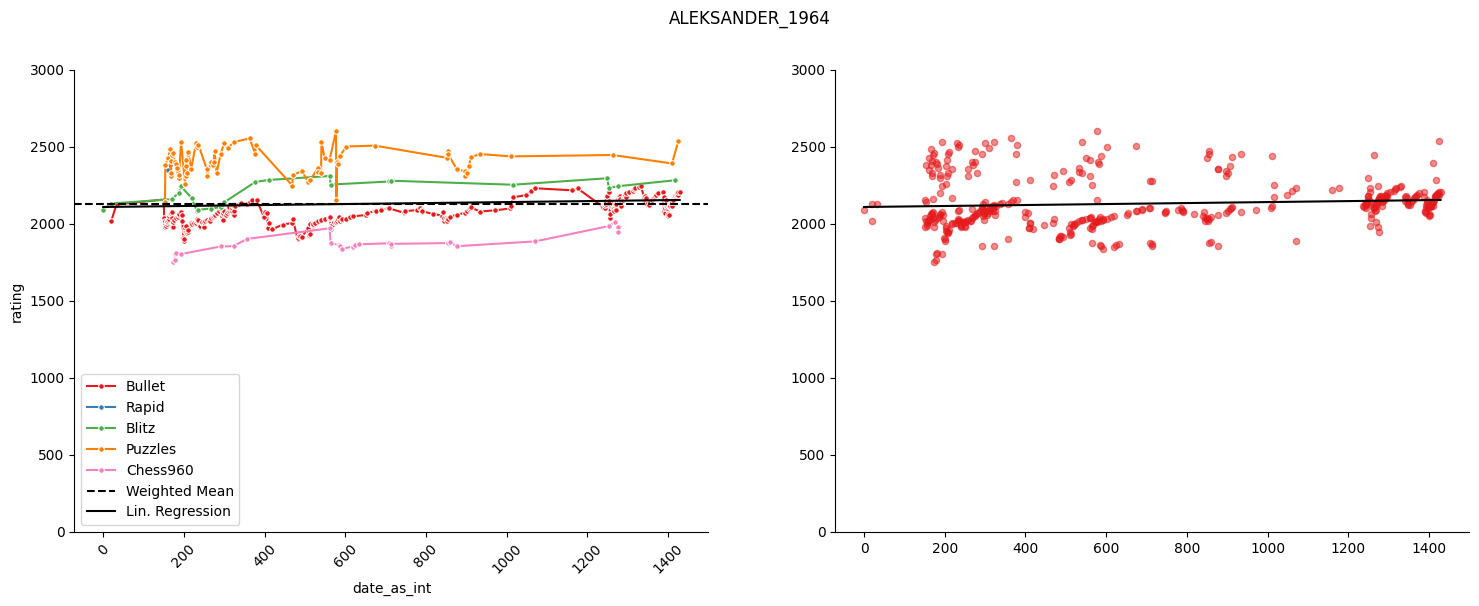

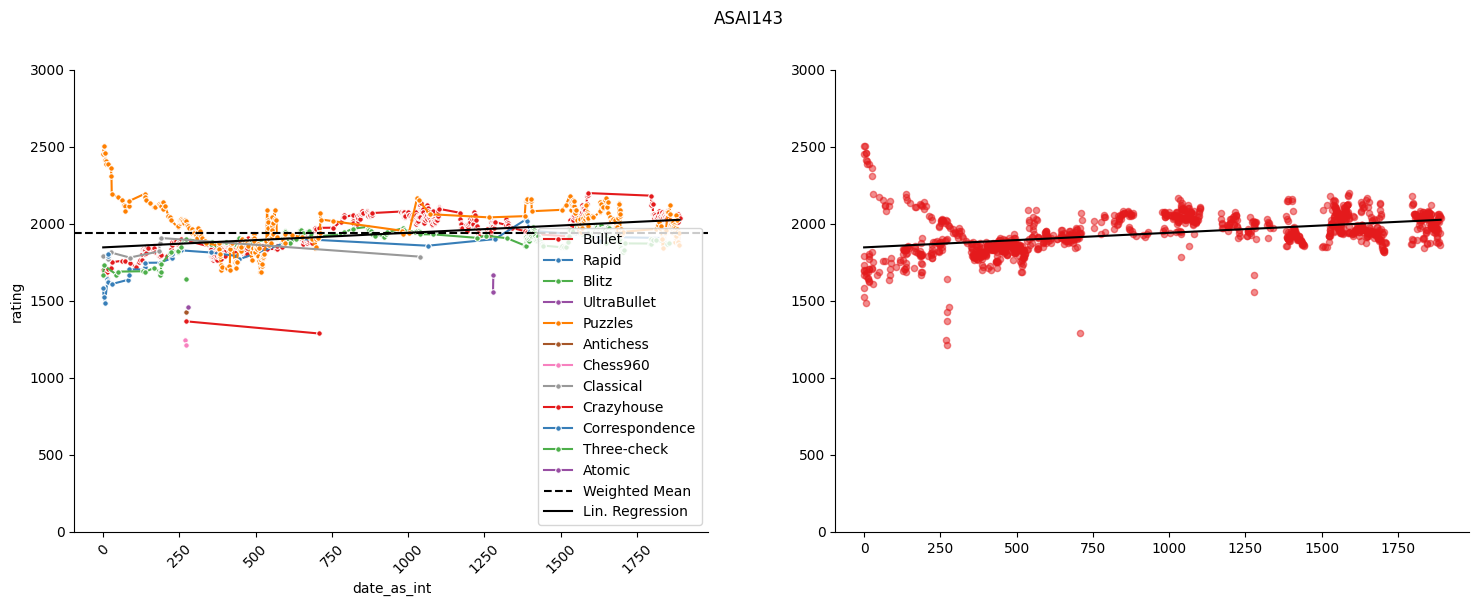

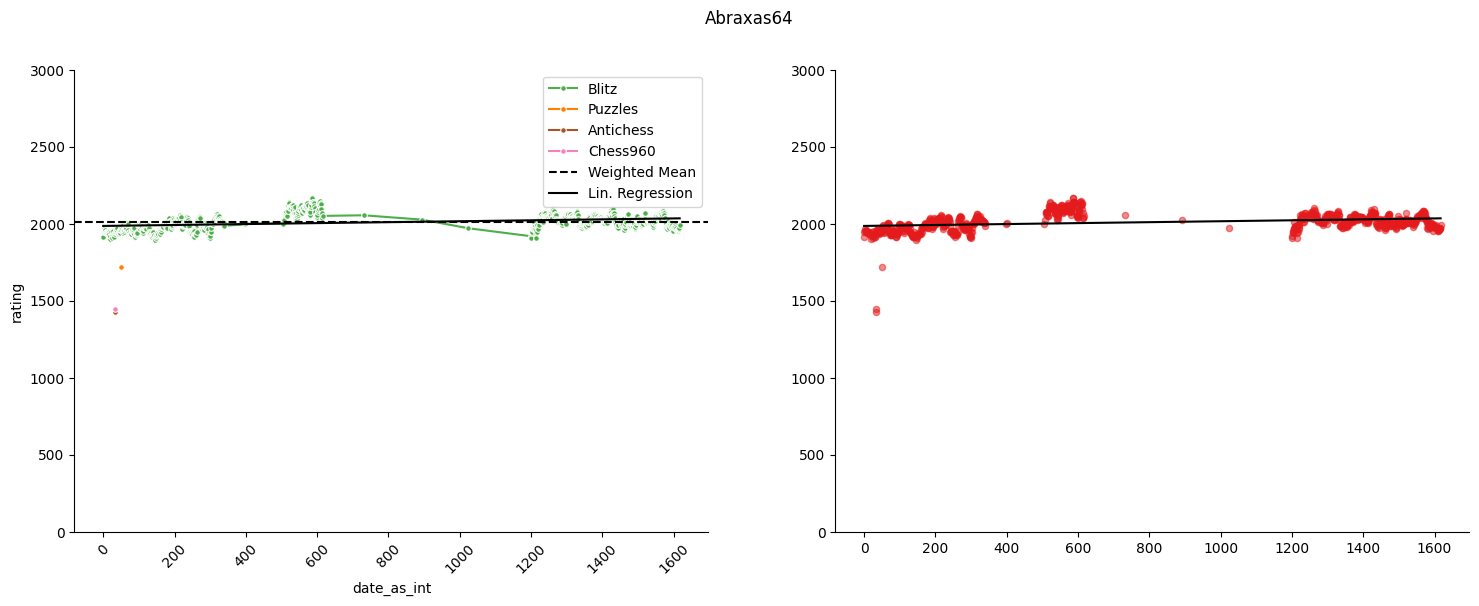

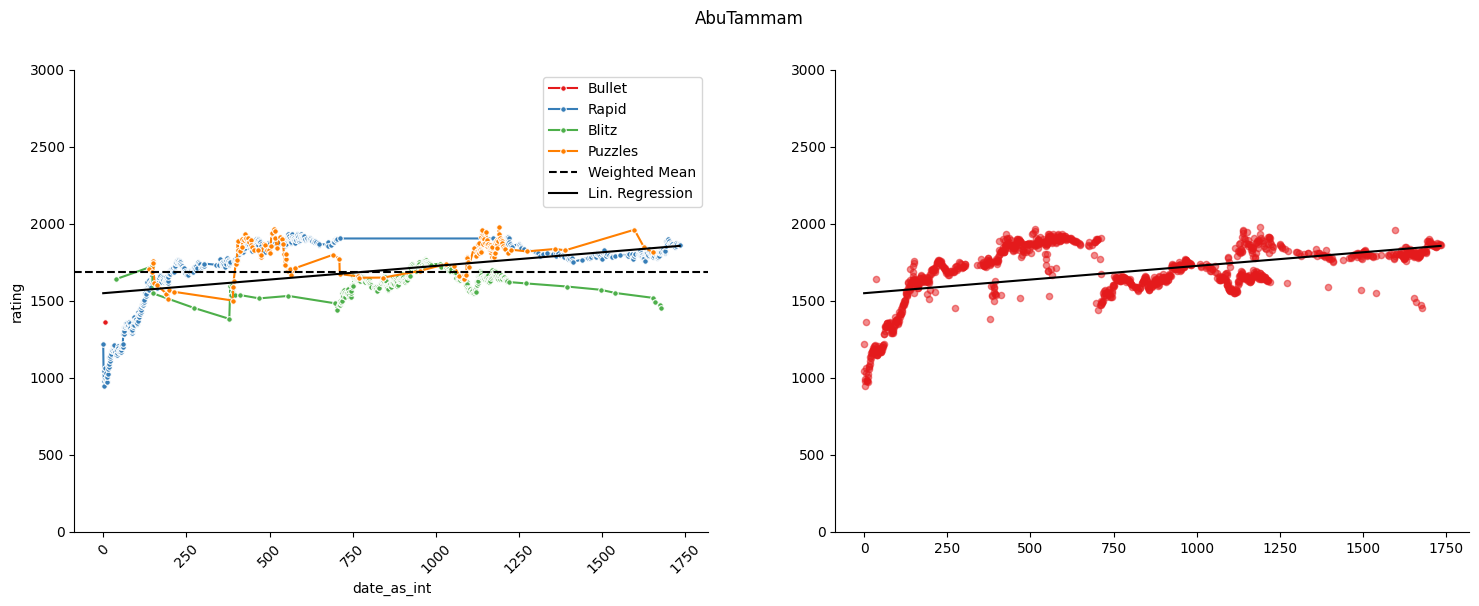

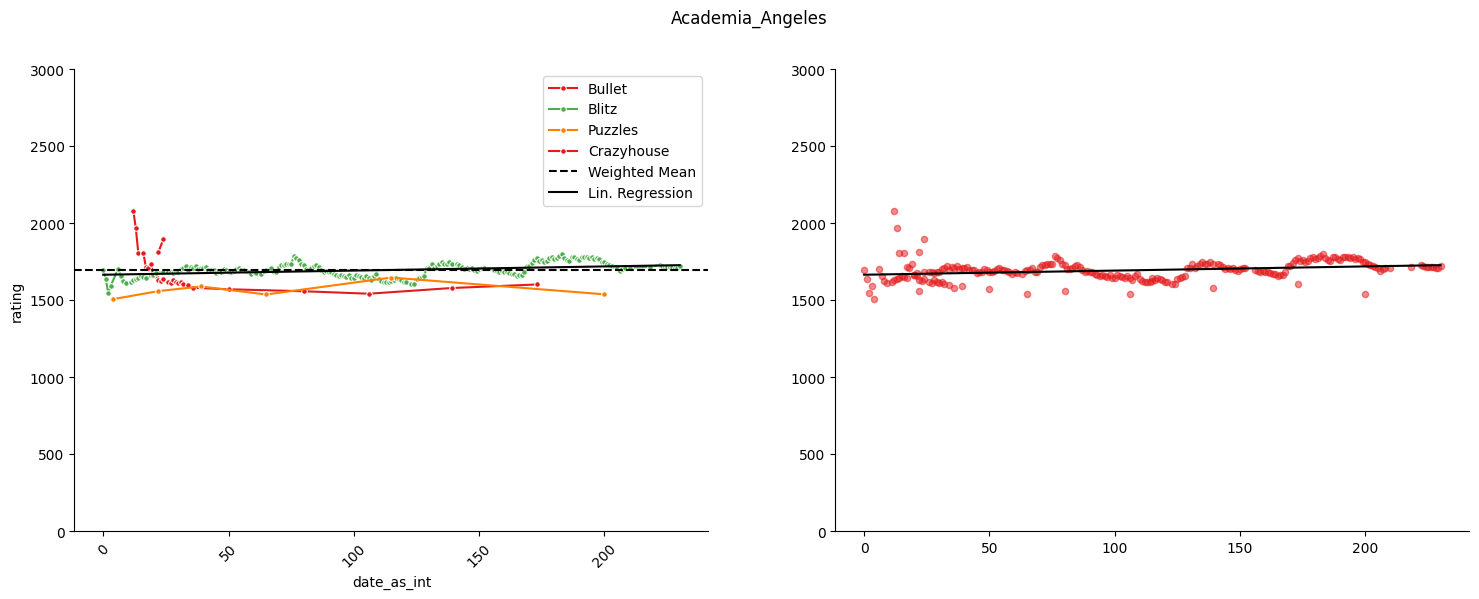

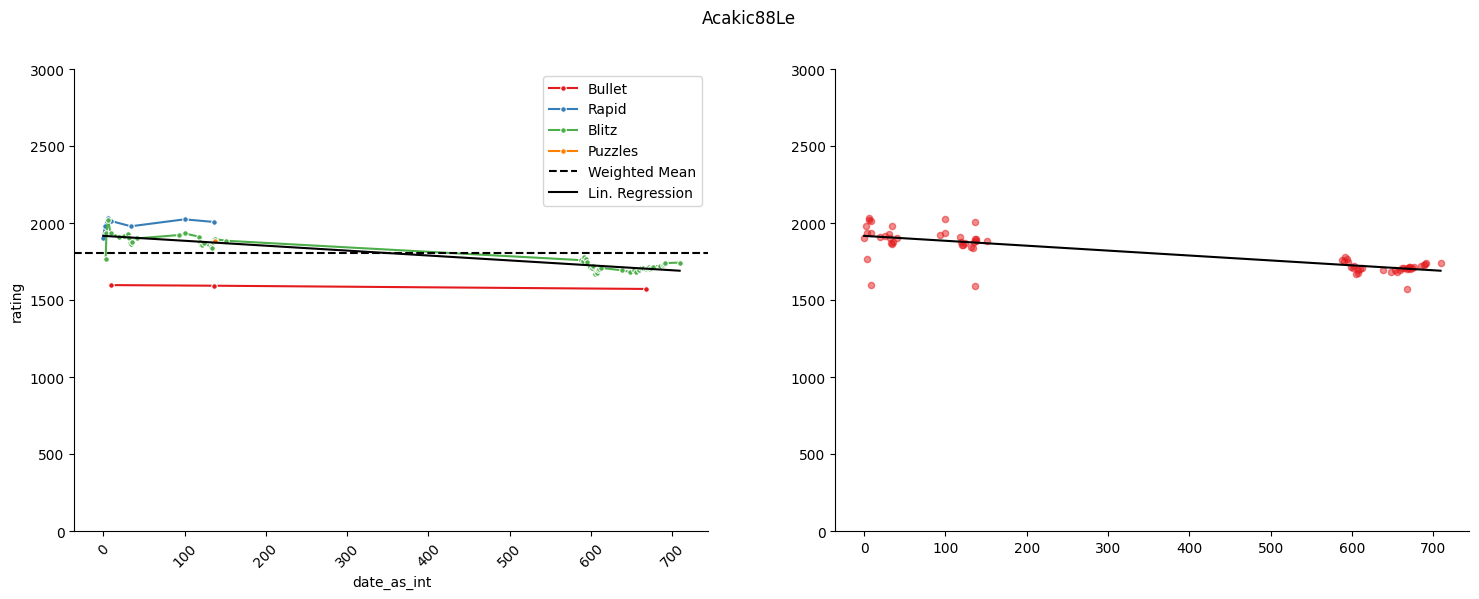

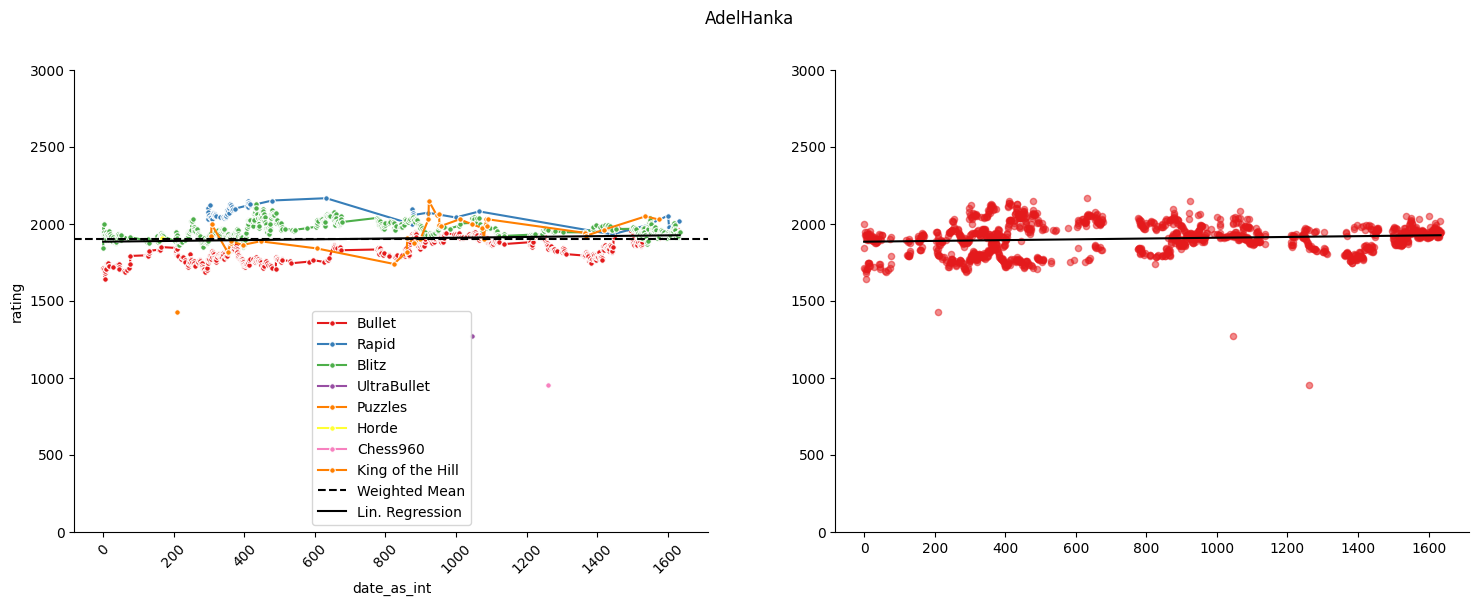

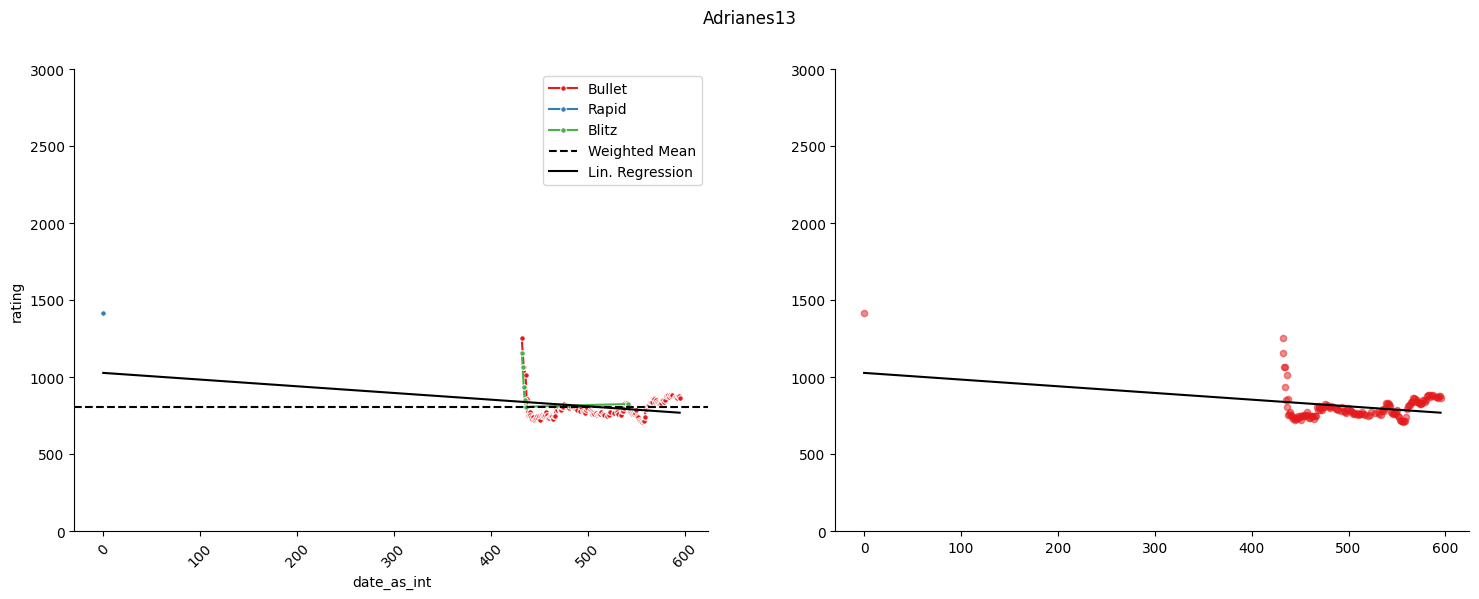

In [55]:
for user in usernames[:10]:
    example = all_ratings[all_ratings.username == user].copy()
    min_date = example["date"].min()
    fig, ax = plt.subplots(1,2, figsize=(18, 6))
    example.loc[:,"date_as_int"] = (example["date"] - min_date).astype(str).apply(str.split).apply(lambda x: x[0]).astype(int)
    # Fit a linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(example["date_as_int"], example["rating"])
    # Predict quitting times based on the regression model
    regression_line = slope * np.array(example["date_as_int"]) + intercept
    
    sns.lineplot(
        example, 
        x="date_as_int", 
        y="rating", 
        hue="mode", 
        hue_order=all_ratings["mode"].unique(), 
        palette="Set1",
        marker=".", 
        markersize= 8, 
        ax=ax[0])
    plt.suptitle(user)
    ax[0].set_ylim((0,3000))

    # Add weighted mean:
    weighted_mean_line = ax[0].axhline(example["rating"].mean(), 0, 1, color="black", linestyle="--", label='Weighted Mean')
    # Add regression line:

    reg_plot = ax[0].plot(example["date_as_int"], regression_line, color='black', label='Lin. Regression')
    
    occurring_modes = example["mode"].unique()
    handles, labels = ax[0].get_legend_handles_labels()
    indices = [i for i, label in enumerate(labels) if label in occurring_modes]
    line = Line2D([0], [0], label='manual line', color='k')

    ax[0].legend(
        handles=[handles[i] for i in indices]+[weighted_mean_line, reg_plot[0]], 
        labels=[labels[i] for i in indices]+ ['Weighted Mean', 'Lin. Regression'])
    ax[0].tick_params(axis='x', rotation=45)

    ax[1].scatter(example["date_as_int"], example["rating"], alpha = 0.5, s=20)
    _ = ax[1].plot(example["date_as_int"], regression_line, color='black', label='Lin. Regression')
    _ = ax[1].set_ylim(0,3000)
    plt.show()

In [26]:
# creating aggregates to save slope and p values for lin_reg fit
aggregates = pd.DataFrame(columns=["username","first_rating", "slope", "pval", "predicted_rating_diff","avg_quit", "number_active_days"])
for user in tqdm(usernames):
    example = all_ratings[all_ratings.username == user].copy()
    min_date = example["date"].min()
    example.loc[:,"date_as_int"] = (example["date"] - min_date).astype(str).apply(str.split).apply(lambda x: x[0]).astype(int)
    # Fit a linear regression using scipy
    slope, intercept, r_value, p_value, std_err = stats.linregress(example["date_as_int"], example["rating"])
    quits = example[example["days_since_prev"]> 0]["days_since_prev"]
    predicted_rating_diff = slope * example["date_as_int"].max()
    avg_quit = quits.mean()
    aggregates.loc[aggregates.shape[0], :] = [user, min_date, slope, p_value, predicted_rating_diff, avg_quit, example.shape[0]]

100%|██████████| 497/497 [00:15<00:00, 31.28it/s]


### Slope and P-value Distribution for fitted Rating Curves

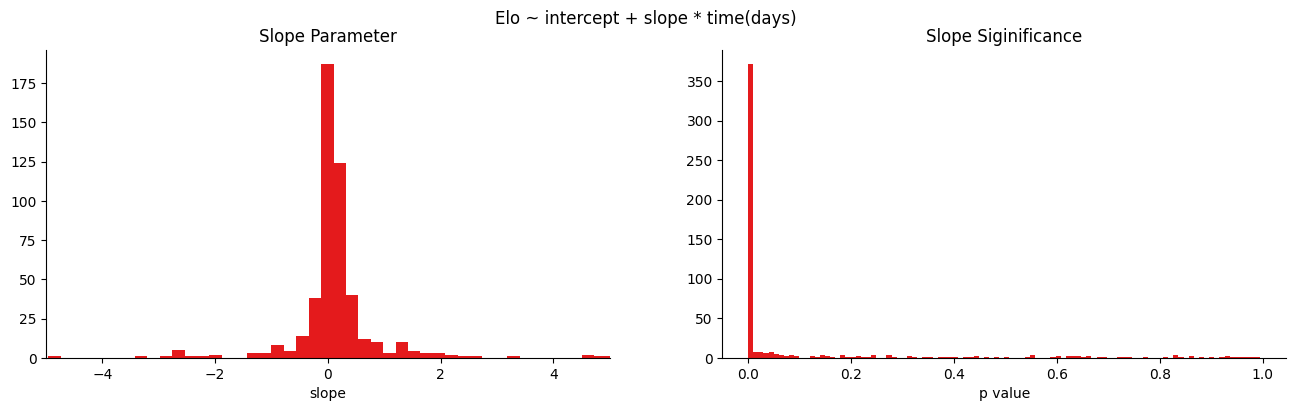

In [27]:
rating_slope = aggregates["slope"].astype(float)
avg_quit= np.log(aggregates["avg_quit"].astype(float))

fig, ax = plt.subplots(1,2, figsize=(16,4))
_ = ax[0].hist(rating_slope, bins=1000)
_ = ax[0].set_xlim(-5,5)
_ = ax[0].set_title("Slope Parameter")
_ = ax[0].set_xlabel("slope")
_ = ax[1].hist(aggregates.pval, bins=100)
_ = ax[1].set_title("Slope Siginificance")
_ = ax[1].set_xlabel("p value")
_ = plt.suptitle("Elo ~ intercept + slope * time(days)")

### Separate Regressions for Significant and Nonsignificant Elo Change

In [32]:
alpha = 0.0001
sign_users = aggregates.username[aggregates["pval"] < alpha ]
non_sign_users = aggregates.username[aggregates["pval"] >= alpha ]

In [49]:
aggregates

,username,first_rating,slope,pval,predicted_rating_diff,avg_quit,number_active_days
0,AJGallivan,2024-02-21 00:00:00,0.009902,0.954537,2.039868,1.0,212
1,AJH1996,2020-09-16 00:00:00,0.275424,0.0,401.842991,1.606828,1575
2,ALEKSANDER_1964,2020-10-11 00:00:00,0.031833,0.072932,45.489128,4.731788,407
3,ASAI143,2019-07-13 00:00:00,0.094784,0.0,179.141778,2.195122,1185
4,Abraxas64,2020-04-09 00:00:00,0.030478,0.0,49.283629,1.981618,820
...,...,...,...,...,...,...,...
492,yxhgt,2022-12-20 00:00:00,0.30399,0.000001,192.729415,1.621483,636
493,zahlenteufel,2018-02-23 00:00:00,0.149456,0.0,357.946558,1.774074,2135
494,zecarneiro67,2023-10-22 00:00:00,1.679658,0.0,549.248312,1.368201,481
495,zloidv,2019-07-15 00:00:00,0.169813,0.0,320.606739,1.309293,2222


                            OLS Regression Results                            
Dep. Variable:        days_since_prev   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1363
Date:                Mon, 07 Oct 2024   Prob (F-statistic):              0.712
Time:                        17:08:17   Log-Likelihood:                -329.26
No. Observations:                 328   AIC:                             662.5
Df Residuals:                     326   BIC:                             670.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7177      0.166      4.312      0.0

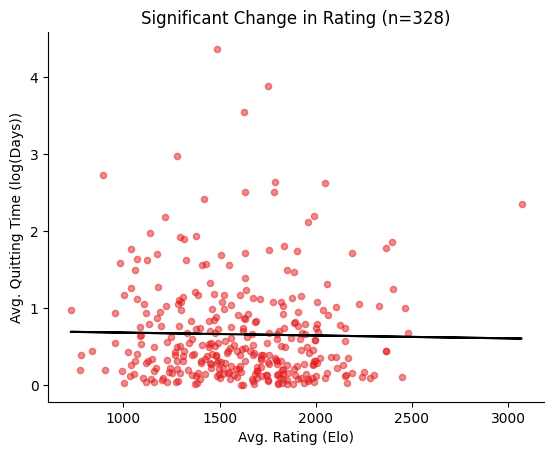

In [56]:
data = all_ratings[["username","rating","days_since_prev"]]
data = data[data["days_since_prev"]> 0]

sign = data[data['username'].isin(sign_users)]
avg_ratings = sign.groupby("username")["rating"].mean()
avg_quitting_times = np.log(sign.groupby("username")["days_since_prev"].mean())
n_sign = len(sign.username.unique())

# fit linear regression model
X = avg_ratings
y = avg_quitting_times
X = sm.add_constant(X)
model = sm.OLS(avg_quitting_times, X).fit()

# view model summary
print(model.summary())

# get parameters for plotting reg. line
intercept, slope = model.params
# Predict quitting times based on the regression model
regression_line = slope * np.array(avg_ratings) + intercept
_ = plt.scatter(avg_ratings, avg_quitting_times, alpha = 0.5, s=20)
_ = plt.plot(avg_ratings, regression_line, color='black', label='Fitted line')
_ = plt.xlabel("Avg. Rating (Elo)")
_ = plt.ylabel("Avg. Quitting Time (log(Days))")
_ = plt.title(f"Significant Change in Rating (n={n_sign})")


                            OLS Regression Results                            
Dep. Variable:        days_since_prev   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.472
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0205
Time:                        17:09:02   Log-Likelihood:                -208.76
No. Observations:                 169   AIC:                             421.5
Df Residuals:                     167   BIC:                             427.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4705      0.247      5.944      0.0

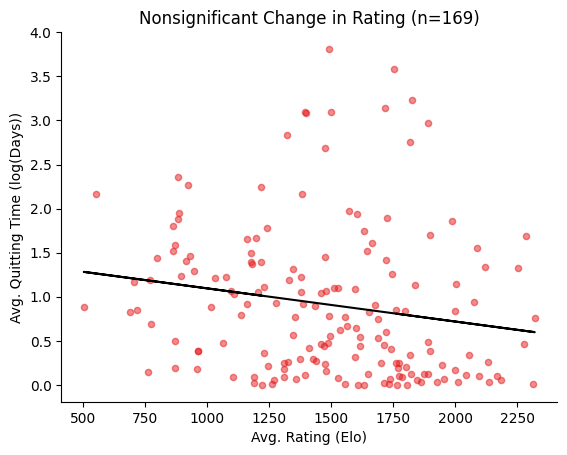

In [57]:
non_sign = data[data['username'].isin(non_sign_users)]
avg_ratings = non_sign.groupby("username")["rating"].mean()
avg_quitting_times = np.log(non_sign.groupby("username")["days_since_prev"].mean())
n_non_sign = len(non_sign.username.unique())
# fit linear regression model
X = avg_ratings
y = avg_quitting_times
X = sm.add_constant(X)
model = sm.OLS(avg_quitting_times, X).fit()

#view model summary
print(model.summary())

#get parameters for plotting reg. line
intercept, slope = model.params


# Predict quitting times based on the regression model
regression_line = slope * np.array(avg_ratings) + intercept
_ = plt.scatter(avg_ratings, avg_quitting_times, alpha = 0.5, s=20)
_ = plt.plot(avg_ratings, regression_line, color='black', label='Fitted line')
_ = plt.xlabel("Avg. Rating (Elo)")
_ = plt.ylabel("Avg. Quitting Time (log(Days))")
_ = plt.title(f"Nonsignificant Change in Rating (n={n_non_sign})")